# **Predicting 3D poses from 2D skeletons**

In this tutorial, we are going to train a neural network to take an input 2D skeleton and predict its 3D pose. An schematic view of the framework is presented in the image below.
![alt text](https://www.cse.iitb.ac.in/PS-Dataset/martinez_overview.png)

The network consists only of FC layers. It uses 2 blocks with residual connection in series. Apart from the input and the output all intermediate layers has 1024 nodes.

In [0]:
!git clone https://github.com/rmitra/DLWorkshop-lab1
%cd DLWorkshop-lab1/
!sh getData.sh

Cloning into 'DLWorkshop-lab1'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 27 (delta 13), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (27/27), done.
/content/DLWorkshop-lab1
--2020-03-04 09:10:24--  https://www.dropbox.com/s/b20gdo2ywkbx87b/dataset_test_gt.pickle
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.1, 2620:100:601b:1::a27d:801
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/b20gdo2ywkbx87b/dataset_test_gt.pickle [following]
--2020-03-04 09:10:24--  https://www.dropbox.com/s/raw/b20gdo2ywkbx87b/dataset_test_gt.pickle
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucf04a04d3c769708b8c00590bbb.dl.dropboxusercontent.com/cd/0/inline/AzSKNeA6_bPhZHQ08XW4hl4SToBtkZaMVS9t0PA

In [0]:
import numpy as np
import torch

import torch.nn as nn
import torch.optim as optim
import os
import sys
from tqdm import tqdm
from time import time
from data_loader import PoseDataset
from common.visualizer import show_pred_pose
import easydict

torch.manual_seed(0)

<font color=red>In following section, the deep learning model performimng 2D to 3D lifting is described. The image below in the Overview section shows the architecture of a residual block.</font>

In [0]:
class PoseModel(nn.Module):
    def __init__(self, num_joints_in, in_features, num_joints_out,
                 dropout=0.25, channels=1024):
        """
        Initialize this model.

        Arguments:
        num_joints_in -- number of input joints (e.g. 17 for Human3.6M)
        in_features -- number of input features for each joint (typically 2 for 2D input)
        num_joints_out -- number of output joints (can be different than input)
        dropout -- dropout probability
        channels -- no nodes in intermediate layer
        """
        super().__init__()

        self.num_joints_in = num_joints_in
        self.in_features = in_features
        self.num_joints_out = num_joints_out

        self.drop = nn.Dropout(dropout)
        self.relu = nn.ReLU(inplace=True)

        self.expand_layer = nn.Linear(num_joints_in * in_features, channels, bias=False)
        self.expand_bn = nn.BatchNorm1d(channels, momentum=0.1)
        self.shrink = nn.Linear(channels, num_joints_out * 3)

        # First block
        self.b1_l1 = nn.Linear(channels, channels, bias=False)
        self.b1_bn1 = nn.BatchNorm1d(channels, momentum=0.1)
        self.b1_l2 = nn.Linear(channels, channels, bias=False)
        self.b1_bn2 = nn.BatchNorm1d(channels, momentum=0.1)
        
        # Second block
        self.b2_l1 = nn.Linear(channels, channels, bias=False)
        self.b2_bn1 = nn.BatchNorm1d(channels, momentum=0.1)
        self.b2_l2 = nn.Linear(channels, channels, bias=False)
        self.b2_bn2 = nn.BatchNorm1d(channels, momentum=0.1)

    def forward(self, x):

        assert len(x.shape) == 2
        assert x.shape[-1] == self.num_joints_in * self.in_features

        # Expand from 2D skeleton to 'channels' features 
        x = self.drop(self.relu(self.expand_bn(self.expand_layer(x)))) # FILL HERE pass through expand linear and BN layer

        # First block
        res_1 = x
        x = self.drop(self.relu(self.b1_bn1(self.b1_l1(x))))
        x = self.drop(self.relu(self.b1_bn2(self.b1_l2(x))))
        x = x + res_1

        # Second block
        res_2 = x
        x = self.drop(self.relu(self.b2_bn1(self.b2_l1(x))))
        x = self.drop(self.relu(self.b2_bn2(self.b2_l2(x))))
        x = x + res_2
        
        x = self.shrink(x) # FILL HERE pass through shrink layer
        return x


<font color=red>The following function is used to calculate both MSE loss for pose regression as well as Mean Per-Joint Position Error(MPJPE) to determine pose prediction accuracy. For MSE, both target and predicted should be of (batch size, num joints * 3). For MPJPE, both target and predicted should be (batch size, num joints, 3).</font>

In [0]:
def mpjpe(predicted, target):
    """
    Mean per-joint position error (i.e. mean Euclidean distance),
    often referred to as "Protocol #1" in many papers.
    """
    assert predicted.shape == target.shape
    return torch.mean(torch.norm(predicted - target, dim=len(target.shape)-1))


<font color=red>The following function describes the training or test loop for one epoch. It can accept 'train' oe 'test' modes. The boolean parameter 'viz_pred' to display predicted 3D poses.</font>

In [0]:
def run_epoch(epoch, args, model_pose, data_loader, optimiser, mode='train', viz_pred=False):

    if mode == 'train':
        model_pose.train()
    else:
        model_pose.eval()

    start_time = time()
    epoch_loss_3d = 0
    mpjpe_epoch = 0.
    N = 0

    for batch_idx, (pose_2d, pose_3d_rel, _) in enumerate(tqdm(data_loader, ascii=True)):

        pose_2d = pose_2d.float()
        pose_3d_rel = pose_3d_rel.float()

        if torch.cuda.is_available():
            pose_2d = pose_2d.cuda()
            pose_3d_rel = pose_3d_rel.cuda()

        optimiser.zero_grad()

        # Predict 3D poses
        predicted_3d_pos = model_pose(pose_2d)

        if viz_pred is True:
            pred_3d_viz = np.zeros((1, 17, 3), dtype='float32')
            pred_3d_viz[:, 1:, :] = predicted_3d_pos[0].detach().cpu().view(16, 3).numpy() * 1000
            pose_2d_viz = pose_2d[0].cpu().view(1, 17, 2).numpy()

            show_pred_pose(pose_2d_viz, pred_3d_viz, n_joints=17)
            from IPython.core.debugger import set_trace
            set_trace()

        # MSE loss between 51 values of predicted_3d_pos and pose_3d_rel
        loss_3d_pos =  mpjpe(predicted_3d_pos, pose_3d_rel)
        epoch_loss_3d += pose_3d_rel.shape[0] * loss_3d_pos.item()

        mpjpe_batch = mpjpe(predicted_3d_pos.detach().view(-1, 16, 3), pose_3d_rel.view(-1, 16, 3))
        mpjpe_epoch = mpjpe_epoch + pose_3d_rel.shape[0] * mpjpe_batch

        N += pose_3d_rel.shape[0]

        loss_total = loss_3d_pos

        if mode == 'train':
            loss_total.backward()
            optimiser.step()

    mpjpe_epoch = mpjpe_epoch / N
    epoch_loss_3d = epoch_loss_3d / N
    elapsed = (time() - start_time) / 60

    print('{}: [{:d}] time {:.2f} 3d_loss {:.3f} Mpjpe {:2f}'.format(
        mode, epoch, elapsed, epoch_loss_3d, mpjpe_epoch * 1000))

    result = dict()
    result['mpjpe'] = mpjpe_epoch * 1000

    return result 



<font color=red>The following code is the starting point of execution. We start with creating data loader for train and test splits.</font>

In [0]:
args = easydict.EasyDict({'batch_size': 64,
        'epochs': 5,
        'learning_rate': 0.001,})
# print(args)

tr_dataset = PoseDataset(args, split='train')
te_dataset = PoseDataset(args, split='test')

train_loader = torch.utils.data.DataLoader(
    tr_dataset,
    batch_size=args.batch_size,
    shuffle=True,
    num_workers=1,
    pin_memory=True,
    drop_last=True
    # worker_init_fn=worker_init_fn
)

test_loader = torch.utils.data.DataLoader(
    te_dataset,
    batch_size=args.batch_size,
    shuffle=False,
    num_workers=1,
    # worker_init_fn=worker_init_fn
)

num_joints_in = tr_dataset.poses_2d.shape[1]  # 17 in our case  
in_features = tr_dataset.poses_2d.shape[2]  # 2 in our case x and y co-ordinates
num_joints_out = tr_dataset.poses_3d.shape[1] - 1  # 17-1=16 in our case ignoring the root as prediction is root relative. 
# n_blocks = 2

Creating train data loader

Creating test data loader



<font color=red>Next we create out 3D pose prediction model, define the optimiser and learning rate schedular.</font>

In [0]:
model_pose = PoseModel(num_joints_in, in_features, num_joints_out, 
                       dropout=0.25, channels=1024)

if torch.cuda.is_available():
    model_pose = model_pose.cuda()

optimizer = optim.Adam(model_pose.parameters(), lr=args.learning_rate, amsgrad=True)
schedular = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

<font color=red>Finally, we start our training and testing for 10 epochs.</font>

In [0]:
epoch = 1
min_mpjpe = 999.0
while epoch < args.epochs:
    _ = run_epoch(epoch, args, model_pose, train_loader, optimizer, 
                  mode='train', viz_pred=False)
    
    result_test = run_epoch(epoch, args, model_pose, train_loader, optimizer, 
                            mode='test', viz_pred=False)

    if result_test['mpjpe'] < min_mpjpe:
        min_mpjpe = result_test['mpjpe']

        torch.save(model_pose.state_dict(), 'checkpoint/model_best.pth')

    epoch = epoch + 1

    schedular.step()



  0%|          | 0/4877 [00:00<?, ?it/s]

train: [1] time 0.65 3d_loss 0.599 Mpjpe 131.952850


  0%|          | 0/4877 [00:00<?, ?it/s]

test: [1] time 0.34 3d_loss 0.314 Mpjpe 64.997078


  0%|          | 0/4877 [00:00<?, ?it/s]

train: [2] time 0.63 3d_loss 0.350 Mpjpe 74.245750


  0%|          | 0/4877 [00:00<?, ?it/s]

test: [2] time 0.34 3d_loss 0.247 Mpjpe 50.947876


  0%|          | 0/4877 [00:00<?, ?it/s]

train: [3] time 0.64 3d_loss 0.315 Mpjpe 66.411659


  0%|          | 0/4877 [00:00<?, ?it/s]

test: [3] time 0.34 3d_loss 0.230 Mpjpe 47.796196


  0%|          | 0/4877 [00:00<?, ?it/s]

train: [4] time 0.65 3d_loss 0.296 Mpjpe 62.356483


100%|##########| 4877/4877 [00:20<00:00, 239.85it/s]

test: [4] time 0.34 3d_loss 0.213 Mpjpe 43.838509


<font color=red>After the training is complete we visualize the predicted poses given a 2D input.</font>

  0%|          | 0/1700 [00:00<?, ?it/s]

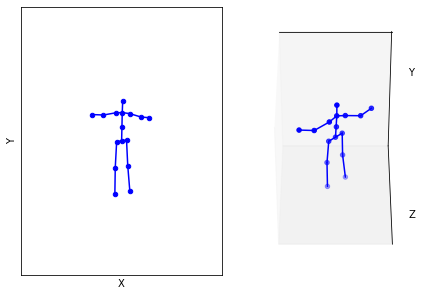

> <ipython-input-6-1cc7e4acba36>(37)run_epoch()
     35 
     36         # MSE loss between 51 values of predicted_3d_pos and pose_3d_rel
---> 37         loss_3d_pos =  mpjpe(predicted_3d_pos, pose_3d_rel)
     38         epoch_loss_3d += pose_3d_rel.shape[0] * loss_3d_pos.item()
     39 



In [0]:
# Visualizing Test predictions
 run_epoch(1, args, model_pose, test_loader, optimizer, mode='test', viz_pred=True) # The first parameter is set to a dummy value 1.